In [1]:
import numpy as np
import pandas as pd
import os
import torch
import torchvision
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, CenterCrop, RandomHorizontalFlip, RandomRotation
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from torchvision import models
import torch.nn as nn
import seaborn as sns
from PIL import Image

In [2]:
labels_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
print(labels_df.head().to_markdown())

|    | id                                       |   label |
|---:|:-----------------------------------------|--------:|
|  0 | f38a6374c348f90b587e046aac6079959adf3835 |       0 |
|  1 | c18f2d887b7ae4f6742ee445113fa1aef383ed77 |       1 |
|  2 | 755db6279dae599ebb4d39a9123cce439965282d |       0 |
|  3 | bc3f0c64fb968ff4a8bd33af6971ecae77c75e08 |       0 |
|  4 | 068aba587a4950175d04c680d38943fd488d6a9d |       0 |


Explore the dataset structure

In [3]:
print("Dataset size:", labels_df.shape)
print("Columns in the dataset:", labels_df.columns)
print("Number of unique IDs:", labels_df['id'].nunique())
print("Value counts of labels:")
print(labels_df['label'].value_counts(normalize=True))

Dataset size: (220025, 2)
Columns in the dataset: Index(['id', 'label'], dtype='object')
Number of unique IDs: 220025
Value counts of labels:
label
0    0.594969
1    0.405031
Name: proportion, dtype: float64


Path to the image directories

In [4]:
train_dir = '/kaggle/input/histopathologic-cancer-detection/train'
test_dir = '/kaggle/input/histopathologic-cancer-detection/test'

Number of images in each directory

In [5]:
print("Number of training images:", len(os.listdir(train_dir)))
print("Number of testing images:", len(os.listdir(test_dir)))

Number of training images: 220025
Number of testing images: 57458


Let's now visualize the distribution of classes

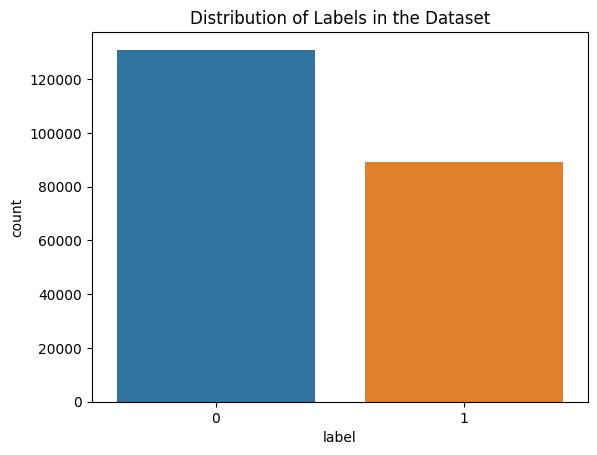

In [6]:
sns.countplot(x='label', data=labels_df)
plt.title('Distribution of Labels in the Dataset')
plt.show()

Display a few images with their labels

In [7]:
def display_images(ids, labels):
    plt.figure(figsize=(10, 5))
    for i, (id, label) in enumerate(zip(ids, labels)):
        plt.subplot(1, len(ids), i + 1)
        img_path = os.path.join(train_dir, f"{id}.tif")
        img = Image.open(img_path)
        plt.imshow(img)
        plt.title(f'Label: {label}')
        plt.axis('off')
    plt.show()

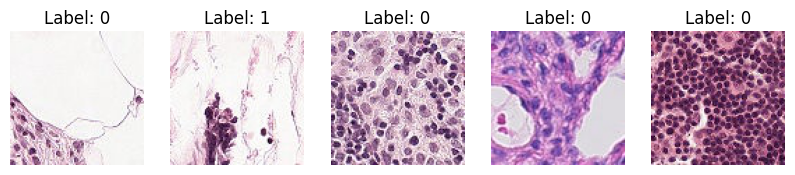

In [8]:
sample_ids = labels_df['id'].head(5)
sample_labels = labels_df['label'].head(5)
display_images(sample_ids, sample_labels)

First of all, making us confident that we are using GPU:

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


### Load a pre-trained ResNet18 model

In [10]:
model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 163MB/s]


# Define transformations for the images

In [11]:
transform = Compose([
    CenterCrop(32),  # Focus on the center 32x32 region
    Resize((96, 96)),  # Resize to the model's expected input size
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [12]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.labels = dataframe['label'].values
        self.file_names = dataframe['id'].values
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.file_names[idx] + '.tif')
        image = Image.open(img_name)
        label = int(self.labels[idx])

        if self.transform:
            image = self.transform(image)

        return image, label

### Creating dataset and data loaders

In [13]:
dataset = CustomDataset(labels_df, train_dir, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [14]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch {epoch + 1}/{num_epochs} - Loss: {running_loss / len(train_loader)}')
        
        # Validation phase
        model.eval()
        total = correct = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'Validation Accuracy: {100 * correct / total:.2f}%')

train_model(model, train_loader, val_loader, criterion, optimizer)

Epoch 1/10 - Loss: 0.41622157477369265
Validation Accuracy: 84.04%
Epoch 2/10 - Loss: 0.3720818910401716
Validation Accuracy: 82.32%
Epoch 3/10 - Loss: 0.33543750641292236
Validation Accuracy: 85.77%
Epoch 4/10 - Loss: 0.31323039993559787
Validation Accuracy: 85.78%
Epoch 5/10 - Loss: 0.29254063359893273
Validation Accuracy: 86.35%
Epoch 6/10 - Loss: 0.26821803542860007
Validation Accuracy: 85.46%
Epoch 7/10 - Loss: 0.23690967304590418
Validation Accuracy: 85.56%
Epoch 8/10 - Loss: 0.20228613918459923
Validation Accuracy: 86.72%
Epoch 9/10 - Loss: 0.16917693296860828
Validation Accuracy: 85.68%
Epoch 10/10 - Loss: 0.14112176079796707
Validation Accuracy: 85.18%


### Now loading test dataset for submission

In [15]:
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.file_names = os.listdir(root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.file_names[idx])
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        # Extract ID from filename
        id = self.file_names[idx].split('.')[0]
        return image, id

test_dataset = TestDataset(root_dir=test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

Predictions on test set:

In [16]:
# Ensure the model is in evaluation mode
model.eval()

predictions = []
image_ids = []
with torch.no_grad():
    for images, ids in test_loader:
        images = images.to(device)
        outputs = model(images)
        # Convert output probabilities to predicted class (0 or 1)
        preds = outputs.argmax(dim=1)
        predictions.extend(preds.cpu().numpy())
        image_ids.extend(ids)

Combine the IDs and predictions into a DataFrame

In [17]:
submission_df = pd.DataFrame({
    'id': image_ids,
    'label': predictions
})

In [19]:
submission_df.to_csv('sample_submission.csv', index=False)